In [1]:
%matplotlib inline

In [ ]:
!git clone https://github.com/marco-c/crashcorrelations

In [2]:
from crashcorrelations import download_data
from crashcorrelations import crash_deviations
from crashcorrelations import plot

from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

In [3]:
versions = download_data.get_versions('nightly')

In [ ]:
download_data.set_token('YOUR_SOCORRO_TOKEN_HERE')
download_data.download_crashes(versions, days=28)

In [4]:
def build_id_before(build_id):
    return int(build_id[0:4]) < 2016 or int(build_id[4:6]) < 7 or int(build_id[6:8]) < 13

def build_id_after(build_id):
    return not build_id_before(build_id)

udf_before = udf(build_id_before, BooleanType())
udf_after = udf(build_id_after, BooleanType())

crashes = crash_deviations.get_crashes(sc, versions=versions, days=28)
# Select Windows 7 crashes
crashes = crashes.filter(crashes['platform_pretty_version'] == 'Windows 7')
# Select NVIDIA crashes.
crashes = crashes.filter(crashes['adapter_vendor_id'] == '0x10de')
# Select driver versions that start with '8.'
crashes = crashes.filter(crashes['adapter_driver_version'].startswith('8.'))

# Select crashes with builds that don't contain the changes from bug 1284322.
df_old_blocklist = crashes.filter(udf_before(crashes['build_id'])).select(['adapter_device_id', 'adapter_driver_version'])
# Select crashes with builds that contain the changes from bug 1284322.
df_new_blocklist = crashes.filter(udf_after(crashes['build_id'])).select(['adapter_device_id', 'adapter_driver_version'])

print(df_old_blocklist.count())
print(df_new_blocklist.count())

1477
204


In [5]:
results = crash_deviations.find_deviations(sc, df_old_blocklist, df_new_blocklist, min_support_diff=0.01, min_corr=0.03, max_addons=0)

1 RULES: 20
2 CANDIDATES: 96
2 RULES: 4


/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


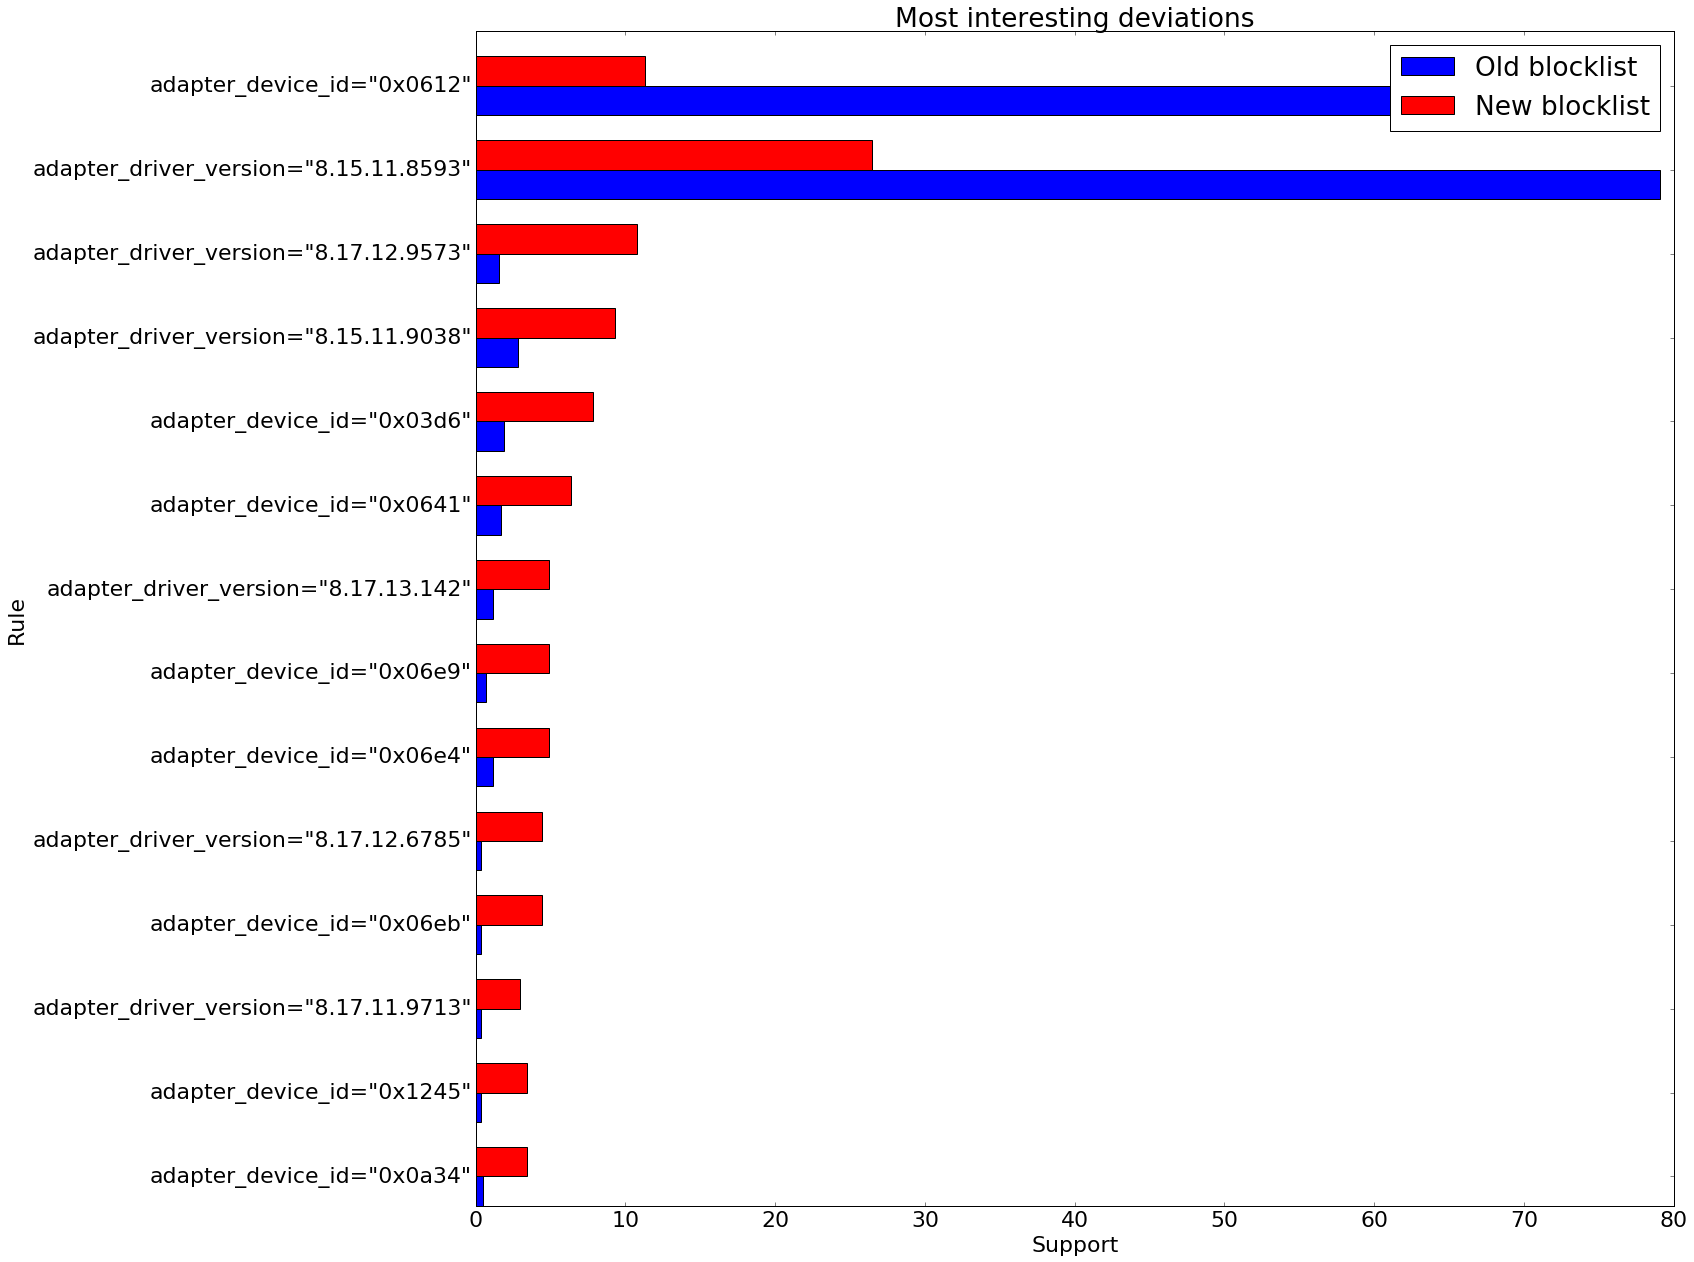

In [6]:
plot.plot([result for result in results if len(result['item']) == 1], 'Old blocklist', 'New blocklist')

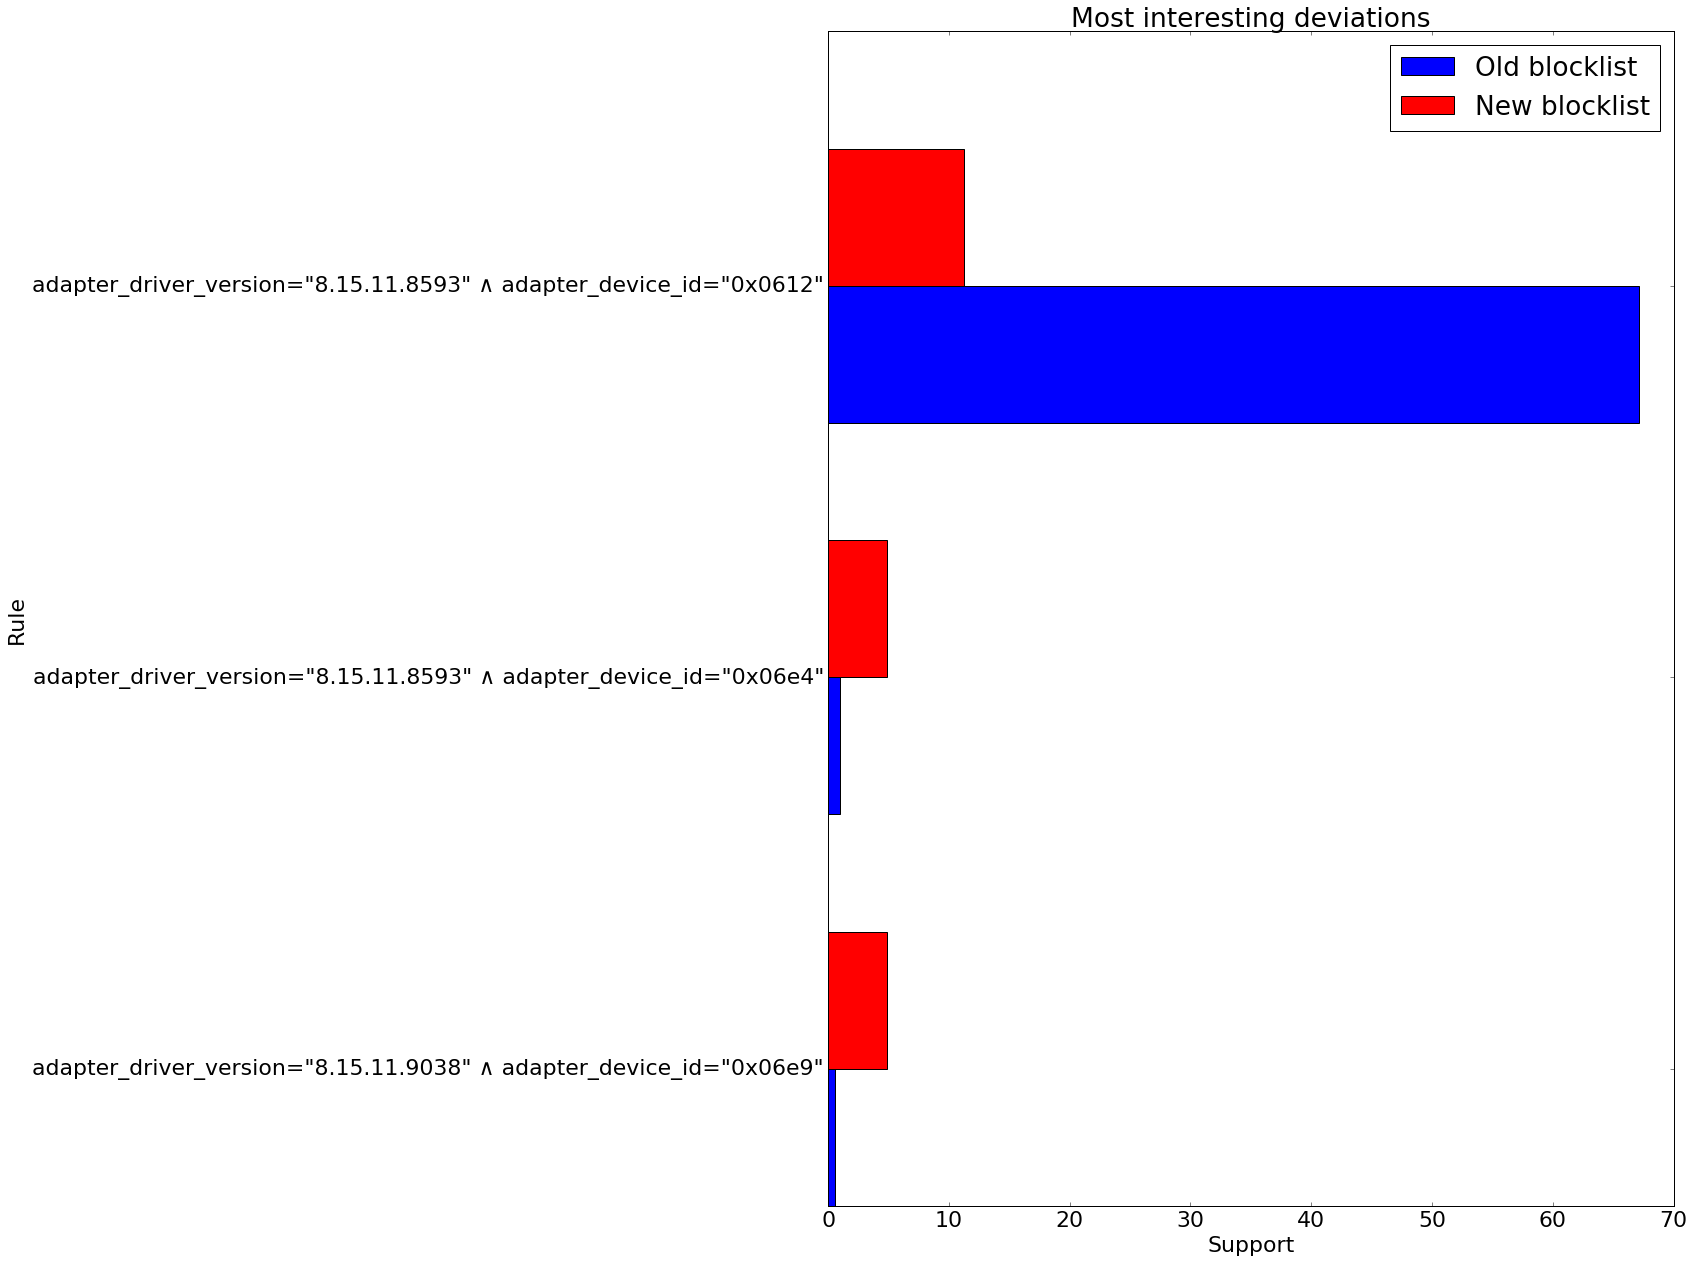

In [7]:
plot.plot([result for result in results if len(result['item']) == 2], 'Old blocklist', 'New blocklist')